# BTC Liquidation Analysis

Computational analysis of liquidation patterns vs BTC price movements

In [1]:
import os
import sys
import warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

sys.path.append('../src')
load_dotenv('../.env')
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Setup complete")

✅ Setup complete


In [2]:
# Configuration
DAYS_BACK = 100  # Use shorter period for better channel access
INTERVAL = "1H"

now_utc = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
start_date = now_utc - timedelta(days=DAYS_BACK)
end_date = now_utc

print(f"📅 Analysis Period: {start_date.strftime('%Y-%m-%d %H:%M')} to {end_date.strftime('%Y-%m-%d %H:%M')}")
print(f"⏱️  Interval: {INTERVAL}")

# Set environment variables
os.environ['START_DATETIME'] = start_date.isoformat()
os.environ['END_DATETIME'] = end_date.isoformat()
os.environ['AGG_INTERVAL'] = INTERVAL
os.environ['DAYS_BACK'] = str(DAYS_BACK)

📅 Analysis Period: 2025-06-11 04:00 to 2025-09-19 04:00
⏱️  Interval: 1H


In [3]:
# Fetch BTC Price Data
from binance_fetch_price import fetch_binance_klines, _interval_binance

print(f"🔄 Fetching BTC price data...")

symbol = "BTCUSDT"
interval = _interval_binance(INTERVAL)
price_df = fetch_binance_klines(symbol, start_date, end_date, interval)

price_path = Path("../data/raw/btc_price.csv")
price_path.parent.mkdir(parents=True, exist_ok=True)
price_df.to_csv(price_path, index=False)

print(f"✅ Fetched {len(price_df)} price records")
print(f"📊 Price range: ${price_df['close'].min():.0f} - ${price_df['close'].max():.0f}")
display(price_df.head())

🔄 Fetching BTC price data...
✅ Fetched 2401 price records
📊 Price range: $98883 - $123848


,timestamp_utc,open,high,low,close,volume
0,2025-06-11 04:59:59.999000+00:00,109722.95,109735.24,109552.68,109562.75,173.09706
1,2025-06-11 05:59:59.999000+00:00,109562.75,109650.59,109430.38,109468.03,198.18742
2,2025-06-11 06:59:59.999000+00:00,109468.04,109679.24,109373.67,109595.01,322.84155
3,2025-06-11 07:59:59.999000+00:00,109595.02,109745.29,109446.73,109446.74,306.34832
4,2025-06-11 08:59:59.999000+00:00,109446.74,109675.69,109446.73,109576.02,413.74462


In [4]:
# Fetch Telegram Messages - Simplified approach
import asyncio
import csv

async def fetch_messages_simple():
    """Simplified message fetching with better error handling"""
    
    try:
        from utils.telethon_client import make_client
        
        API_ID = int(os.getenv("TELEGRAM_API_ID", "0"))
        API_HASH = os.getenv("TELEGRAM_API_HASH", "")
        SESSION = os.getenv("TELEGRAM_SESSION", ".telegram_session")
        CHANNEL_ID = int(os.getenv("TELEGRAM_GROUP_ID", "1407057468"))
        
        if not API_ID or not API_HASH:
            print("❌ Missing Telegram credentials in .env file")
            return False
        
        print(f"🔄 Connecting to channel {CHANNEL_ID}...")
        
        messages = []
        
        async with make_client(API_ID, API_HASH, SESSION) as client:
            channel = await client.get_entity(CHANNEL_ID)
            print(f"✅ Connected to: {channel.title}")
            
            count = 0
            async for message in client.iter_messages(channel, limit=1000):
                if message.text and "liquidated" in message.text.lower():
                    msg_time = message.date.astimezone(timezone.utc)
                    
                    # Check if within our date range
                    if start_date <= msg_time <= end_date:
                        messages.append({
                            "message_id": message.id,
                            "timestamp_utc": msg_time.isoformat(timespec="seconds"),
                            "text": message.text.replace("\r", " ").replace("\n", " ")
                        })
                        count += 1
                
                # Stop if we have enough recent messages
                if count >= 500:
                    break
        
        # Save messages
        messages_path = Path("../data/raw/telegram_messages.csv")
        messages_path.parent.mkdir(parents=True, exist_ok=True)
        
        with messages_path.open("w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["message_id", "timestamp_utc", "text"])
            for msg in messages:
                writer.writerow([msg["message_id"], msg["timestamp_utc"], msg["text"]])
        
        print(f"✅ Fetched {len(messages)} liquidation messages")
        print(f"💾 Saved to: {messages_path}")
        
        return len(messages) > 0
        
    except Exception as e:
        print(f"❌ Error fetching messages: {e}")
        print("💡 Check your Telegram credentials and channel access")
        return False

# Run the fetch
print("🔄 Fetching Telegram messages...")
success = await fetch_messages_simple()

if success:
    # Load and display results
    msg_df = pd.read_csv("../data/raw/telegram_messages.csv")
    print(f"📊 Sample messages:")
    display(msg_df.head())
else:
    print("⚠️  Using sample data for demonstration")
    # Create sample data if real fetch fails
    sample_messages = [
        {
            "message_id": 1,
            "timestamp_utc": (now_utc - timedelta(hours=2)).isoformat(),
            "text": "📉[Binance] Liquidated Long on BTCUSDT @ $116,368: Sell $1,163,687"
        },
        {
            "message_id": 2,
            "timestamp_utc": (now_utc - timedelta(hours=1)).isoformat(),
            "text": "📈[Bybit] liquidated Short on BTCUSDT @ $117,756: Buy $63,117"
        }
    ]
    
    sample_df = pd.DataFrame(sample_messages)
    sample_path = Path("../data/raw/telegram_messages.csv")
    sample_path.parent.mkdir(parents=True, exist_ok=True)
    sample_df.to_csv(sample_path, index=False)
    print(f"📊 Created sample data with {len(sample_messages)} messages")

🔄 Fetching Telegram messages...
🔄 Connecting to channel 1407057468...
✅ Connected to: WhaleBot Rektd ☠️
✅ Fetched 500 liquidation messages
💾 Saved to: ../data/raw/telegram_messages.csv
📊 Sample messages:


,message_id,timestamp_utc,text
0,393833,2025-09-19T03:51:34+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...
1,393832,2025-09-19T03:51:08+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...
2,393830,2025-09-19T03:49:22+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...
3,393829,2025-09-19T03:42:52+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...
4,393828,2025-09-19T03:42:51+00:00,📉[Binance](https://whalebot.co/BinanceFutures)...


In [5]:
# Load and process data
def load_and_process_data():
    """Load price and liquidation data, return merged dataset"""
    
    # Load price data
    price_path = Path("../data/raw/btc_price.csv")
    if not price_path.exists():
        print("❌ Price data not found. Run price fetching cell first.")
        return None
    
    price_df = pd.read_csv(price_path, parse_dates=["timestamp_utc"])
    print(f"📊 Loaded {len(price_df)} price records")
    
    # Load messages
    msg_path = Path("../data/raw/telegram_messages.csv")
    if not msg_path.exists():
        print("❌ Message data not found. Run message fetching cell first.")
        return None
    
    msg_df = pd.read_csv(msg_path, parse_dates=["timestamp_utc"])
    print(f"📊 Loaded {len(msg_df)} messages")
    
    # Parse liquidations
    from parse_aggregate import parse_row
    
    parsed = msg_df["text"].apply(parse_row)
    msg_df["side"] = parsed.apply(lambda x: x[0])
    msg_df["amount_usd"] = parsed.apply(lambda x: x[1])
    
    # Filter valid liquidations
    liq_df = msg_df.dropna(subset=["side", "amount_usd"]).copy()
    btc_liq = liq_df[liq_df["text"].str.contains("BTC", case=False, na=False)]
    
    if len(btc_liq) == 0:
        print("⚠️  No BTC liquidations found, using all liquidations")
        btc_liq = liq_df
    
    print(f"📊 Found {len(btc_liq)} liquidations ({len(btc_liq[btc_liq['side']=='long'])} long, {len(btc_liq[btc_liq['side']=='short'])} short)")
    
    if len(btc_liq) == 0:
        print("❌ No valid liquidations found")
        return None
    
    # Aggregate by hour
    btc_liq = btc_liq.set_index("timestamp_utc").sort_index()
    
    agg_data = pd.DataFrame({
        "long_liq_usd": btc_liq[btc_liq["side"] == "long"].resample("1H")["amount_usd"].sum(),
        "short_liq_usd": btc_liq[btc_liq["side"] == "short"].resample("1H")["amount_usd"].sum(),
        "long_count": btc_liq[btc_liq["side"] == "long"].resample("1H")["side"].count(),
        "short_count": btc_liq[btc_liq["side"] == "short"].resample("1H")["side"].count(),
    }).fillna(0.0).reset_index()
    
    # Merge with price data using nearest timestamp matching
    from pandas import merge_asof
    
    dataset = merge_asof(
        agg_data.sort_values("timestamp_utc"),
        price_df[["timestamp_utc", "close", "volume"]].sort_values("timestamp_utc"),
        on="timestamp_utc",
        direction="nearest",
        tolerance=pd.Timedelta(minutes=30)
    )
    
    dataset = dataset.dropna(subset=["close"])
    
    if len(dataset) == 0:
        print("❌ No matching timestamps found")
        return None
    
    # Engineer features
    dataset["net_liq_usd"] = dataset["short_liq_usd"] - dataset["long_liq_usd"]
    dataset["total_liq_usd"] = dataset["short_liq_usd"] + dataset["long_liq_usd"]
    dataset["price_change"] = dataset["close"].pct_change()
    dataset["price_change_next"] = dataset["close"].pct_change().shift(-1)
    
    print(f"✅ Created dataset with {len(dataset)} records")
    return dataset

# Load data
data = load_and_process_data()
if data is not None:
    print(f"📅 Data range: {data['timestamp_utc'].min()} to {data['timestamp_utc'].max()}")
    print(f"💰 Total liquidations: ${data['total_liq_usd'].sum():,.0f}")
    display(data.head())

📊 Loaded 2401 price records
📊 Loaded 500 messages
📊 Found 87 liquidations (25 long, 62 short)
✅ Created dataset with 34 records
📅 Data range: 2025-09-17 18:00:00+00:00 to 2025-09-19 03:00:00+00:00
💰 Total liquidations: $15,271,182


,timestamp_utc,long_liq_usd,short_liq_usd,long_count,short_count,close,volume,net_liq_usd,total_liq_usd,price_change,price_change_next
0,2025-09-17 18:00:00+00:00,1490435.0,767774.0,11,6.0,115504.48,696.96558,-722661.0,2258209.0,NaN,-0.002403
1,2025-09-17 19:00:00+00:00,0.0,560482.0,0,5.0,115226.93,3427.38872,560482.0,560482.0,-0.002403,0.003689
2,2025-09-17 20:00:00+00:00,0.0,235808.0,0,2.0,115652.02,955.04331,235808.0,235808.0,0.003689,-0.000264
3,2025-09-17 21:00:00+00:00,643479.0,600701.0,2,3.0,115621.47,455.26463,-42778.0,1244180.0,-0.000264,0.003606
4,2025-09-17 22:00:00+00:00,0.0,2584951.0,0,17.0,116038.39,336.05085,2584951.0,2584951.0,0.003606,0.004492


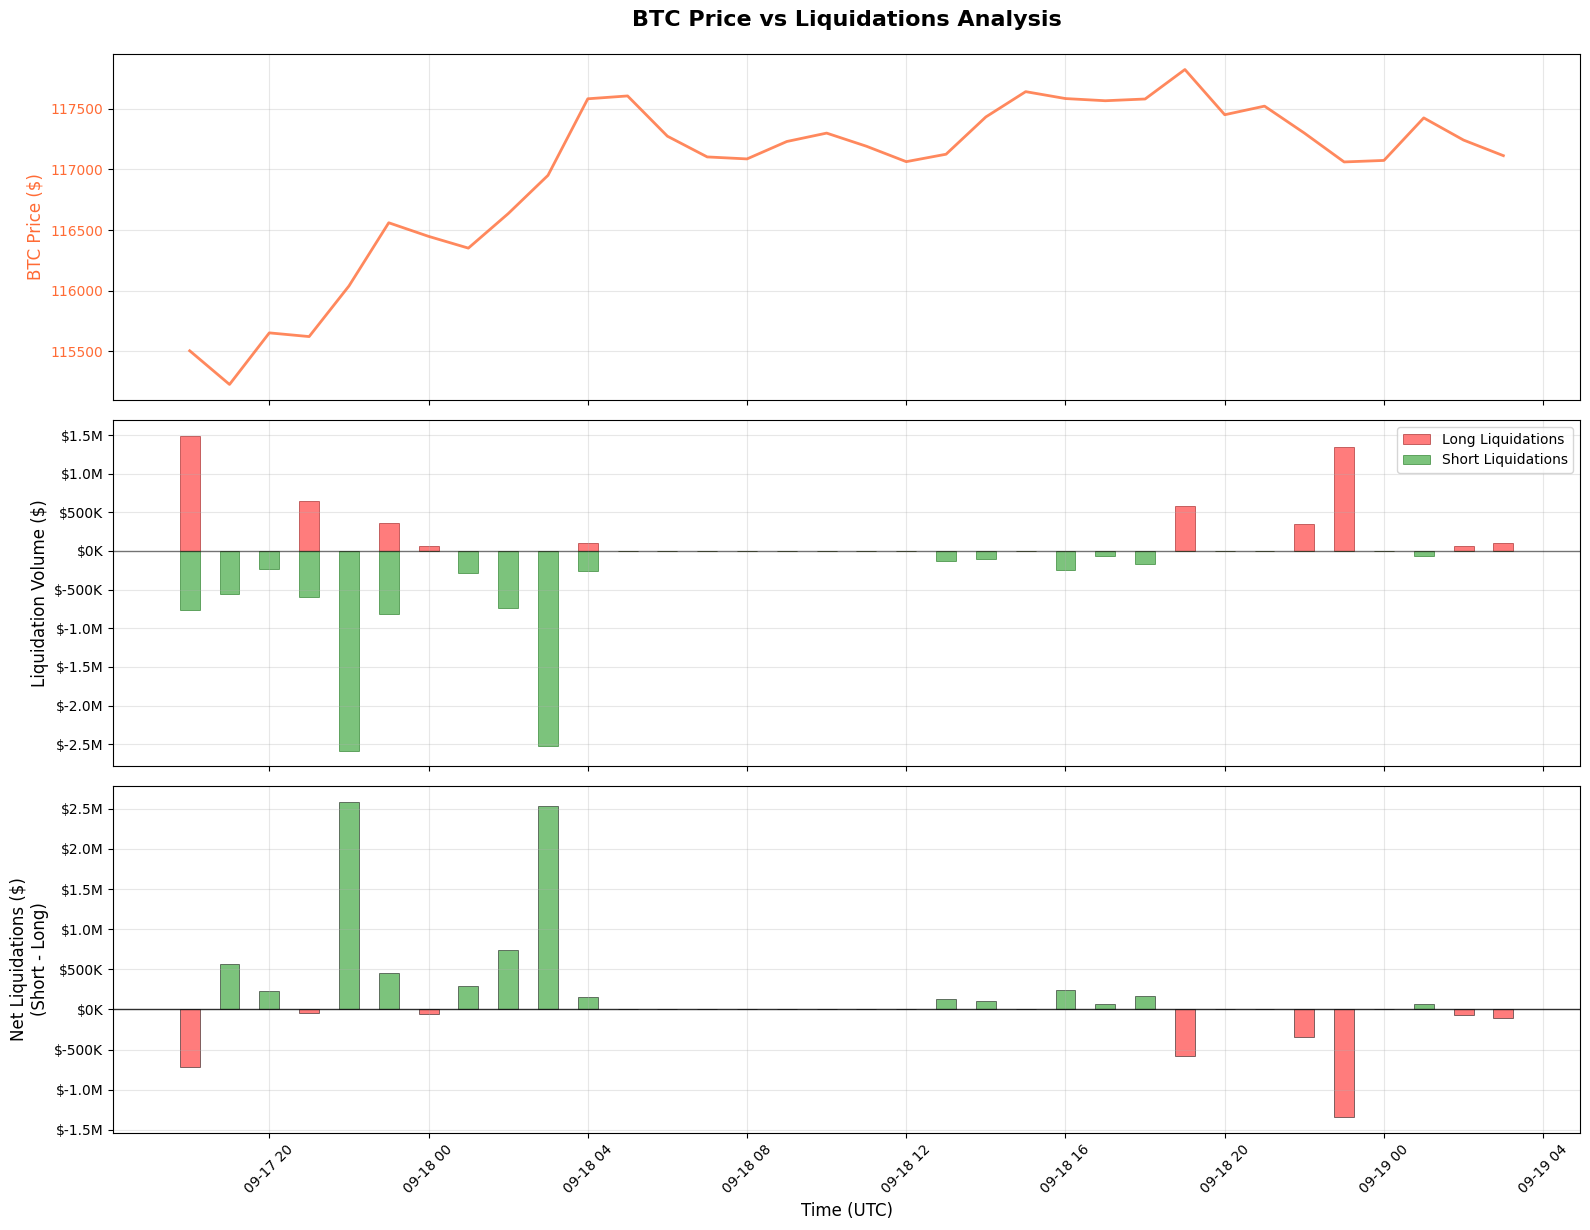

💾 Saved timeline visualization


In [6]:
# Visualization 1: Price vs Liquidations Timeline
if data is not None and len(data) > 0:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    # 1. BTC Price
    ax1.plot(data['timestamp_utc'], data['close'], color='#FF6B35', linewidth=2, alpha=0.8)
    ax1.set_ylabel('BTC Price ($)', fontsize=12, color='#FF6B35')
    ax1.tick_params(axis='y', labelcolor='#FF6B35')
    ax1.set_title('BTC Price vs Liquidations Analysis', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # 2. Liquidations (Long vs Short)
    width = pd.Timedelta(minutes=30)
    ax2.bar(data['timestamp_utc'], data['long_liq_usd'], width=width, 
            alpha=0.7, color='#FF4444', label='Long Liquidations', edgecolor='darkred', linewidth=0.5)
    ax2.bar(data['timestamp_utc'], -data['short_liq_usd'], width=width, 
            alpha=0.7, color='#44AA44', label='Short Liquidations', edgecolor='darkgreen', linewidth=0.5)
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax2.set_ylabel('Liquidation Volume ($)', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if abs(x) >= 1e6 else f'${x/1e3:.0f}K'))
    
    # 3. Net Liquidations (Short - Long)
    colors = ['#44AA44' if x > 0 else '#FF4444' for x in data['net_liq_usd']]
    ax3.bar(data['timestamp_utc'], data['net_liq_usd'], width=width, 
            alpha=0.7, color=colors, edgecolor='black', linewidth=0.5)
    
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
    ax3.set_ylabel('Net Liquidations ($)\n(Short - Long)', fontsize=12)
    ax3.set_xlabel('Time (UTC)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if abs(x) >= 1e6 else f'${x/1e3:.0f}K'))
    
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
    
    # Save plot
    fig.savefig('../data/processed/liquidation_timeline.png', dpi=300, bbox_inches='tight')
    print("💾 Saved timeline visualization")

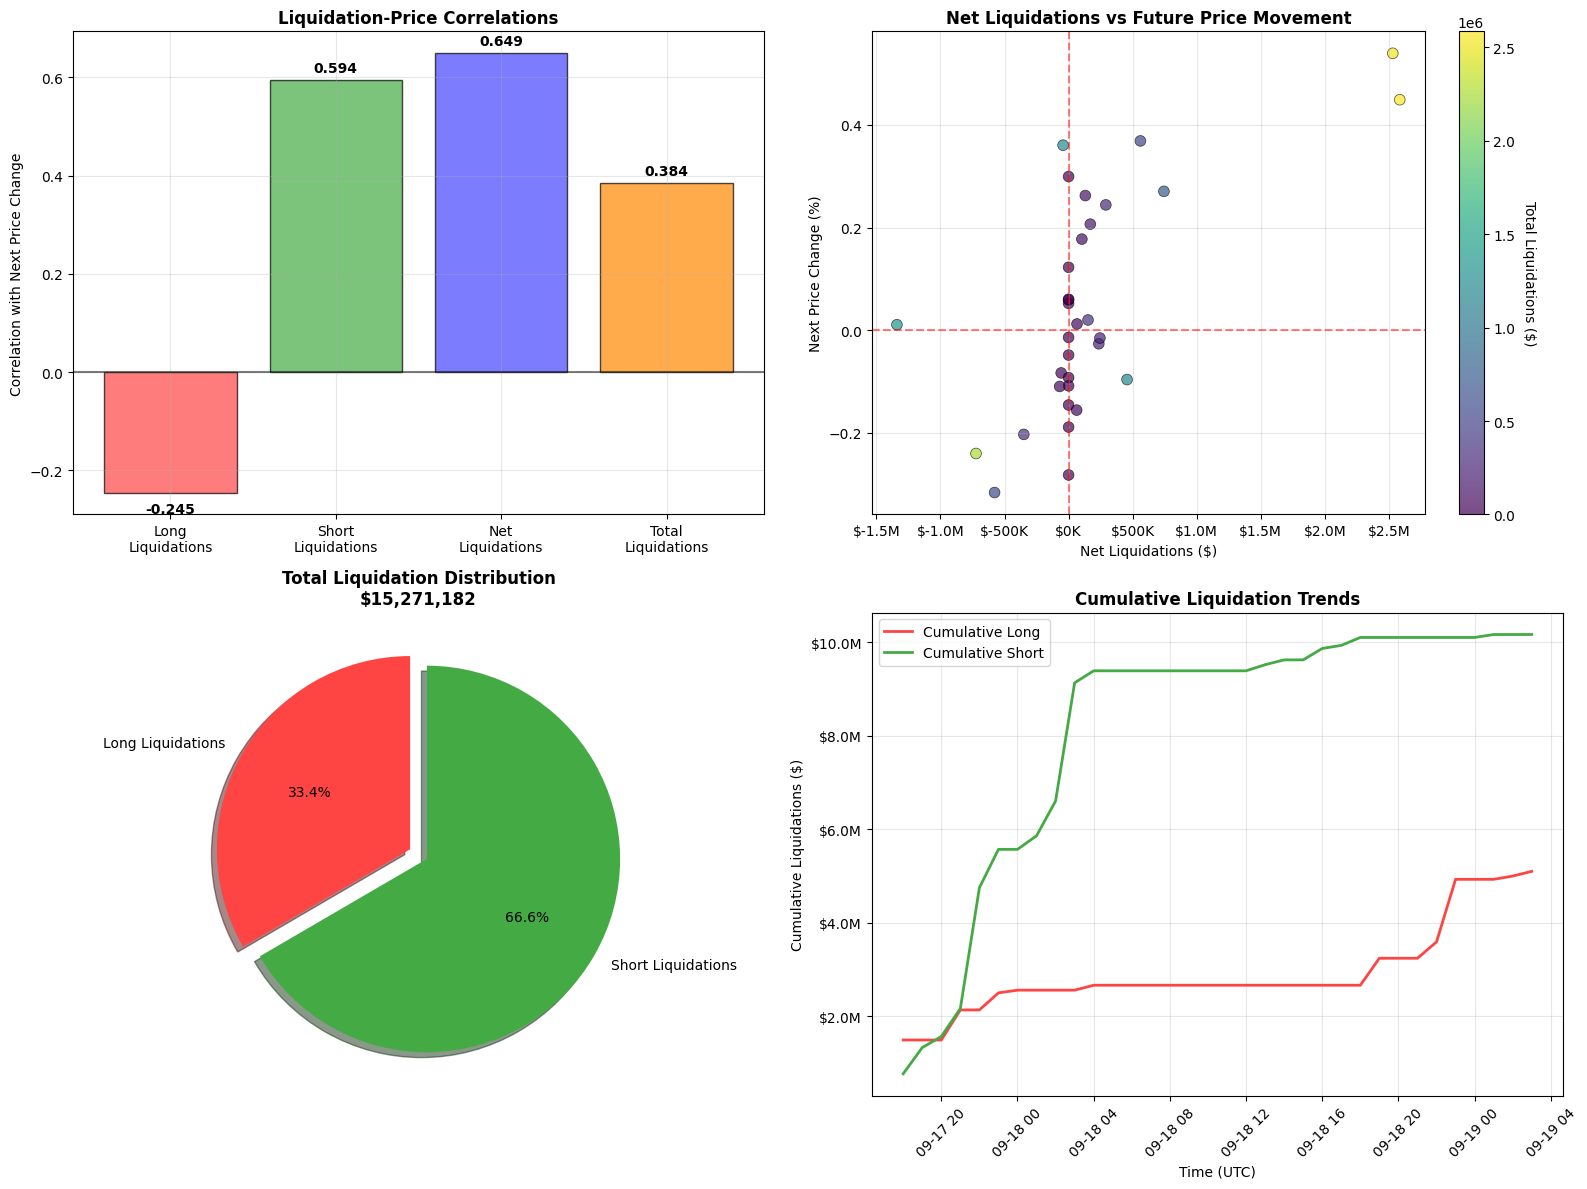

💾 Saved correlation analysis

📊 CORRELATION SUMMARY:
Long Liquidations: -0.2450 (Moderate Negative)
Short Liquidations: 0.5942 (Strong Positive)
Net Liquidations: 0.6492 (Strong Positive)
Total Liquidations: 0.3844 (Strong Positive)


In [7]:
# Visualization 2: Correlation Analysis
if data is not None and len(data) > 1:
    # Calculate correlations
    correlations = {
        'Long Liquidations': data['long_liq_usd'].corr(data['price_change_next']),
        'Short Liquidations': data['short_liq_usd'].corr(data['price_change_next']),
        'Net Liquidations': data['net_liq_usd'].corr(data['price_change_next']),
        'Total Liquidations': data['total_liq_usd'].corr(data['price_change_next'])
    }
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Correlation Bar Chart
    corr_names = list(correlations.keys())
    corr_values = [correlations[k] for k in corr_names]
    colors = ['#FF4444', '#44AA44', '#4444FF', '#FF8800']
    
    bars = ax1.bar(range(len(corr_names)), corr_values, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xticks(range(len(corr_names)))
    ax1.set_xticklabels([name.replace(' ', '\n') for name in corr_names])
    ax1.set_ylabel('Correlation with Next Price Change')
    ax1.set_title('Liquidation-Price Correlations', fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # Add correlation values on bars
    for bar, val in zip(bars, corr_values):
        if not pd.isna(val):
            ax1.text(bar.get_x() + bar.get_width()/2, val + (0.01 if val >= 0 else -0.02),
                    f'{val:.3f}', ha='center', va='bottom' if val >= 0 else 'top', fontweight='bold')
    
    # 2. Scatter: Net Liquidations vs Price Change
    valid_data = data.dropna(subset=['net_liq_usd', 'price_change_next'])
    if len(valid_data) > 0:
        scatter = ax2.scatter(valid_data['net_liq_usd'], valid_data['price_change_next']*100, 
                             c=valid_data['total_liq_usd'], cmap='viridis', alpha=0.7, s=60, 
                             edgecolors='black', linewidth=0.5)
        ax2.set_xlabel('Net Liquidations ($)')
        ax2.set_ylabel('Next Price Change (%)')
        ax2.set_title('Net Liquidations vs Future Price Movement', fontweight='bold')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        ax2.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Total Liquidations ($)', rotation=270, labelpad=15)
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if abs(x) >= 1e6 else f'${x/1e3:.0f}K'))
    
    # 3. Liquidation Distribution
    long_total = data['long_liq_usd'].sum()
    short_total = data['short_liq_usd'].sum()
    
    if long_total > 0 or short_total > 0:
        ax3.pie([long_total, short_total], labels=['Long Liquidations', 'Short Liquidations'], 
                colors=['#FF4444', '#44AA44'], autopct='%1.1f%%', startangle=90, 
                explode=(0.05, 0.05), shadow=True)
        ax3.set_title(f'Total Liquidation Distribution\n${(long_total + short_total):,.0f}', fontweight='bold')
    
    # 4. Cumulative Liquidations
    data_sorted = data.sort_values('timestamp_utc')
    ax4.plot(data_sorted['timestamp_utc'], data_sorted['long_liq_usd'].cumsum(), 
             color='#FF4444', linewidth=2, label='Cumulative Long')
    ax4.plot(data_sorted['timestamp_utc'], data_sorted['short_liq_usd'].cumsum(), 
             color='#44AA44', linewidth=2, label='Cumulative Short')
    
    ax4.set_xlabel('Time (UTC)')
    ax4.set_ylabel('Cumulative Liquidations ($)')
    ax4.set_title('Cumulative Liquidation Trends', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))
    
    plt.tight_layout()
    plt.show()
    
    # Save plot
    fig.savefig('../data/processed/correlation_analysis.png', dpi=300, bbox_inches='tight')
    print("💾 Saved correlation analysis")
    
    # Print correlation summary
    print("\n📊 CORRELATION SUMMARY:")
    print("=" * 40)
    for name, corr in correlations.items():
        if not pd.isna(corr):
            strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
            direction = "Positive" if corr > 0 else "Negative"
            print(f"{name}: {corr:.4f} ({strength} {direction})")
        else:
            print(f"{name}: No correlation (insufficient data)")

In [8]:
# Summary Dashboard
if data is not None and len(data) > 0:
    total_liq = data['total_liq_usd'].sum()
    long_liq = data['long_liq_usd'].sum()
    short_liq = data['short_liq_usd'].sum()
    
    print("\n" + "="*60)
    print("📊 LIQUIDATION ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\n📅 Analysis Period:")
    print(f"   From: {data['timestamp_utc'].min()}")
    print(f"   To:   {data['timestamp_utc'].max()}")
    print(f"   Duration: {len(data)} hours")
    
    print(f"\n💰 Liquidation Summary:")
    print(f"   Total Liquidations: ${total_liq:,.0f}")
    if total_liq > 0:
        print(f"   Long Liquidations:  ${long_liq:,.0f} ({long_liq/total_liq*100:.1f}%)")
        print(f"   Short Liquidations: ${short_liq:,.0f} ({short_liq/total_liq*100:.1f}%)")
    
    print(f"\n📈 BTC Price Summary:")
    print(f"   Price Range: ${data['close'].min():,.0f} - ${data['close'].max():,.0f}")
    print(f"   Volatility: {data['price_change'].std()*100:.2f}%")
    
    print(f"\n🔍 Key Correlations:")
    correlations = {
        'Net → Future Price': data['net_liq_usd'].corr(data['price_change_next']),
        'Long → Future Price': data['long_liq_usd'].corr(data['price_change_next']),
        'Short → Future Price': data['short_liq_usd'].corr(data['price_change_next'])
    }
    
    for name, corr in correlations.items():
        if not pd.isna(corr):
            strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
            direction = "Positive" if corr > 0 else "Negative"
            print(f"   {name}: {corr:.4f} ({strength} {direction})")
    
    print("\n✅ Analysis Complete!")
    print("="*60)
else:
    print("❌ No data available for analysis")


📊 LIQUIDATION ANALYSIS SUMMARY

📅 Analysis Period:
   From: 2025-09-17 18:00:00+00:00
   To:   2025-09-19 03:00:00+00:00
   Duration: 34 hours

💰 Liquidation Summary:
   Total Liquidations: $15,271,182
   Long Liquidations:  $5,100,470 (33.4%)
   Short Liquidations: $10,170,712 (66.6%)

📈 BTC Price Summary:
   Price Range: $115,227 - $117,823
   Volatility: 0.22%

🔍 Key Correlations:
   Net → Future Price: 0.6492 (Strong Positive)
   Long → Future Price: -0.2450 (Moderate Negative)
   Short → Future Price: 0.5942 (Strong Positive)

✅ Analysis Complete!
